<a href="https://colab.research.google.com/github/Loga19818eeanvesh/GenerativeAdversarialNetworks_GANs_Assignments/blob/main/c1w1_GAN_for_generating_handwritten_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [2]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_generator_block
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        # Hint: Replace all of the "None" with the appropriate dimensions.
        # The documentation may be useful if you're less familiar with PyTorch:
        # https://pytorch.org/docs/stable/nn.html.
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
        #### END CODE HERE ####
    )


In [3]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Generator
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            # There is a dropdown with hints if you need them! 
            #### START CODE HERE ####
            nn.Linear(hidden_dim * 8,im_dim),
            nn.Sigmoid()
            #### END CODE HERE ####
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

In [4]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_noise
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device 
    # argument to the function you use to generate the noise.
    #### START CODE HERE ####
    noise = torch.randn(n_samples,z_dim,device =device)
    return noise
    #### END CODE HERE ####

In [5]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_discriminator_block
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2,inplace=True)
        #### END CODE HERE ####
    )

In [6]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE ####
            nn.Linear(hidden_dim, 1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [7]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cuda'
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [8]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [9]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_disc_loss
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!
    #### START CODE HERE ####
    noise = get_noise(num_images, z_dim, device=device)
    images = gen(noise)
    outputs = disc(images.detach())
    targets = torch.zeros_like(outputs)
    loss = criterion(outputs,targets)

    real_outputs = disc(real)
    targets_real = torch.ones_like(real_outputs)
    loss_real = criterion(real_outputs,targets_real)

    disc_loss = (loss+loss_real)/2

    #### END CODE HERE ####
    return disc_loss

In [11]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    #### START CODE HERE ####
    noise = get_noise(num_images, z_dim, device=device)
    images = gen(noise)
    outputs = disc(images)
    targets = torch.ones_like(outputs)
    gen_loss = criterion(outputs,targets)
    #### END CODE HERE ####
    return gen_loss

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.3880863704681392, discriminator loss: 0.4192592334151274


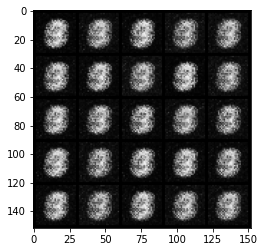

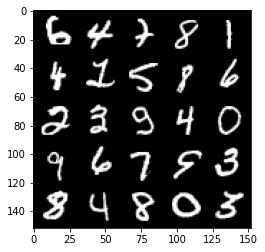

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.6689650263786295, discriminator loss: 0.30028116425871876


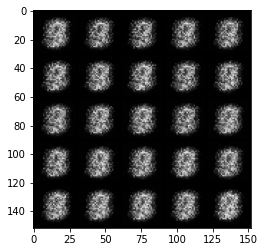

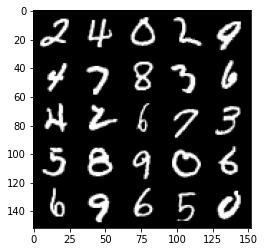

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.9593469610214238, discriminator loss: 0.17415257668495152


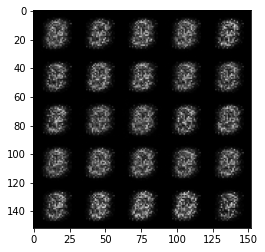

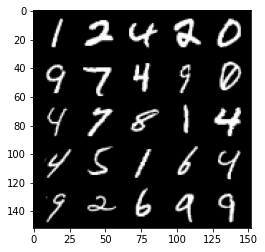

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.7621222927570344, discriminator loss: 0.1956253527104855


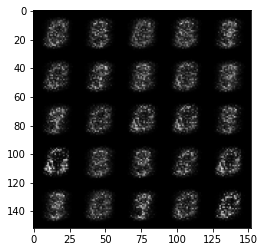

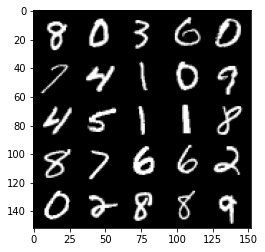

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.7262687559127803, discriminator loss: 0.1948897701203824


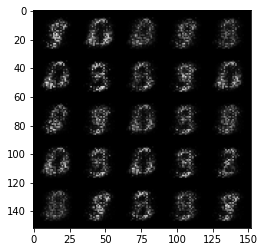

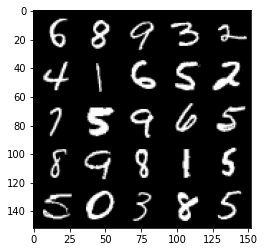

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 2.0249788150787356, discriminator loss: 0.1510555897951126


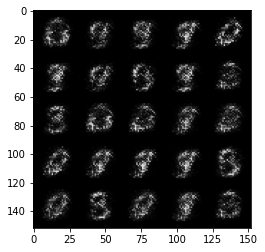

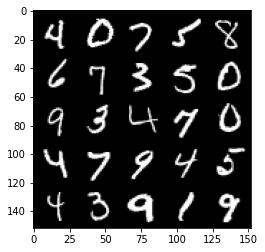

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 2.402163200855254, discriminator loss: 0.12600728003680695


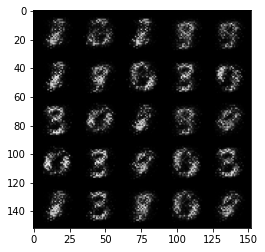

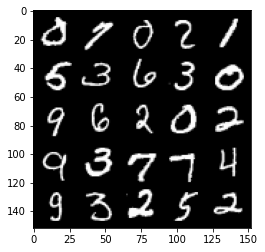

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.7092508234977712, discriminator loss: 0.1251295041739941


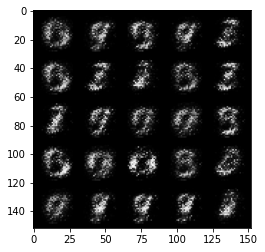

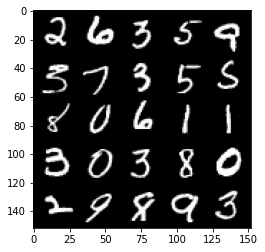

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 3.185977814674373, discriminator loss: 0.09972721417248243


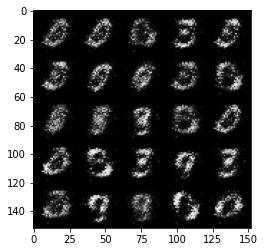

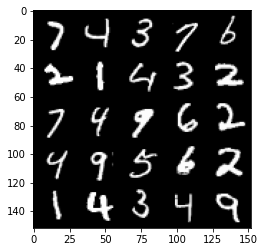

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 3.4596895565986623, discriminator loss: 0.08045303206145772


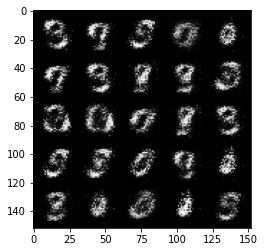

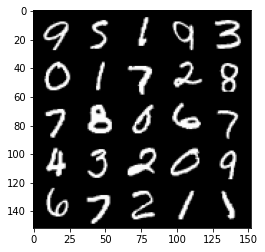

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 3.74385336732864, discriminator loss: 0.0799176804944873


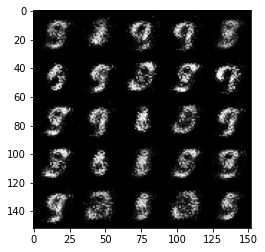

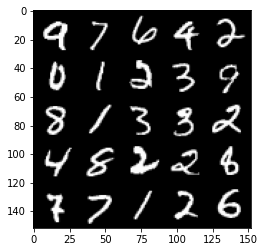

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 3.7594187216758765, discriminator loss: 0.07857221792638304


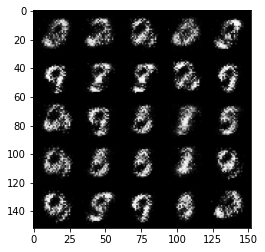

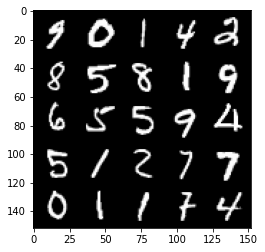

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 3.901934449672699, discriminator loss: 0.06379558699578043


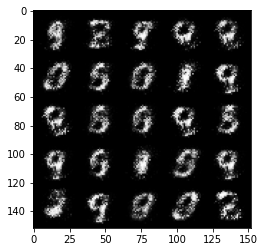

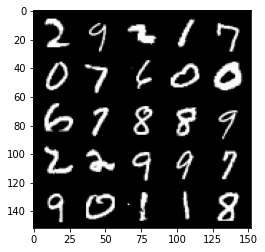

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 3.9911224088668815, discriminator loss: 0.05121823263540862


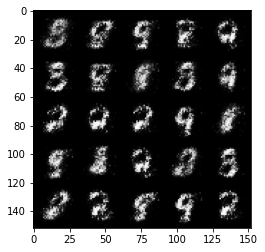

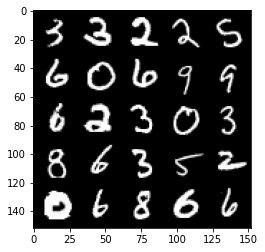

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 4.117860516071322, discriminator loss: 0.04745734241232279


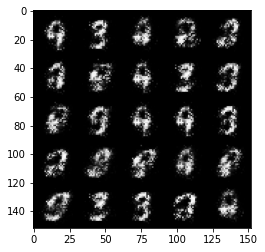

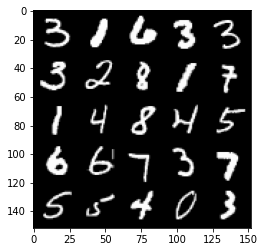

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 4.1102423205375676, discriminator loss: 0.051639268822968064


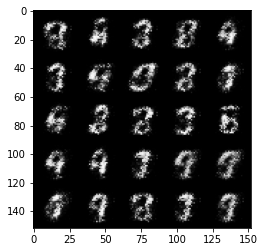

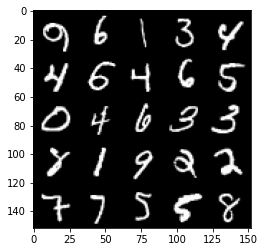

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 4.05608614492416, discriminator loss: 0.05761038658395411


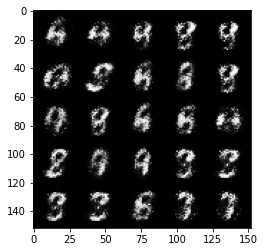

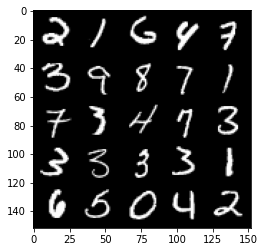

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 4.193668779373168, discriminator loss: 0.0652612106874586


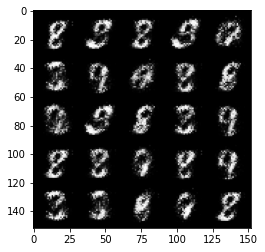

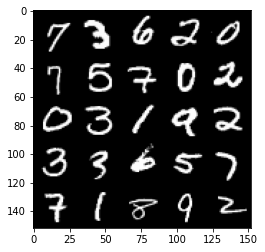

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 4.139429272651674, discriminator loss: 0.05934772003814574


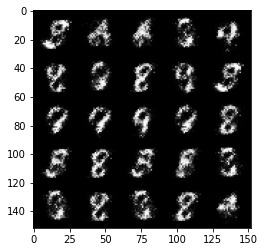

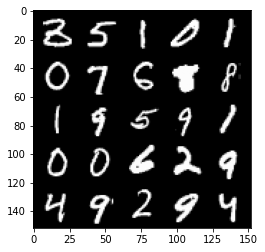

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 4.15946598625183, discriminator loss: 0.06688883487135174


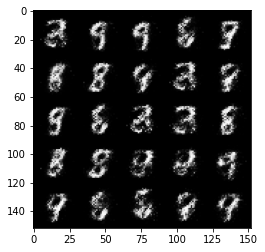

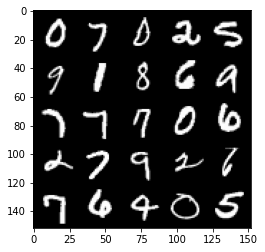

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 3.940160140514375, discriminator loss: 0.07603019231930372


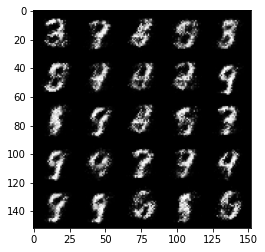

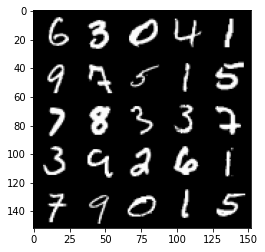

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 3.9819825882911646, discriminator loss: 0.07194628411531458


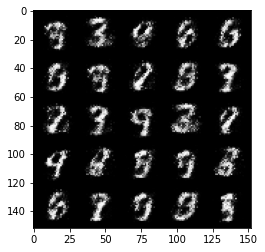

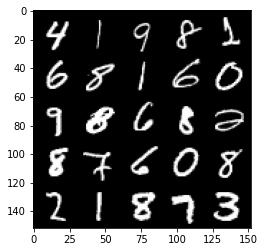

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 3.8641503186225896, discriminator loss: 0.07990778619050984


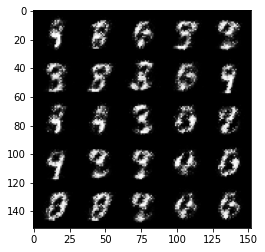

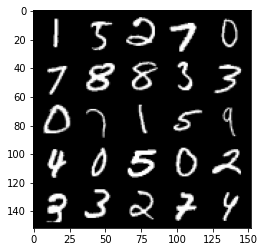

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 3.855944655418395, discriminator loss: 0.07921883541345602


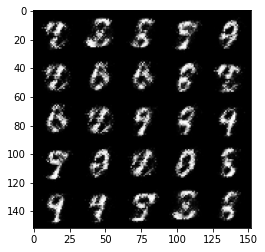

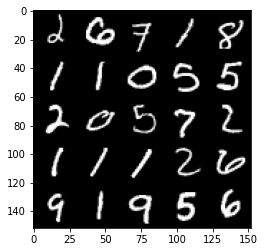

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 3.718758085250851, discriminator loss: 0.09874209172278632


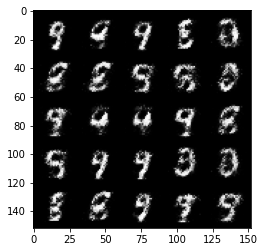

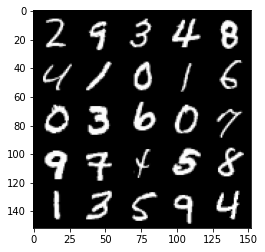

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 3.664926981925965, discriminator loss: 0.1054040553569793


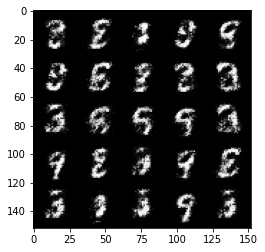

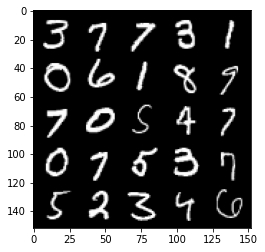

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 3.867738954067231, discriminator loss: 0.092208155810833


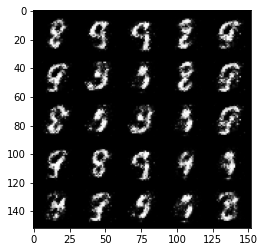

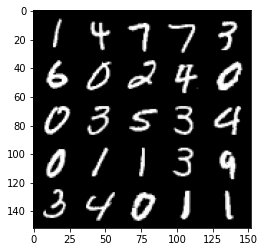

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 3.550451254367826, discriminator loss: 0.12125770934671162


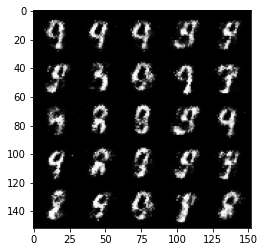

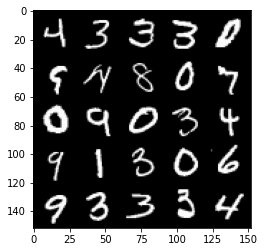

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 3.5775562829971355, discriminator loss: 0.10047641449421649


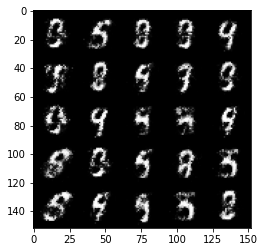

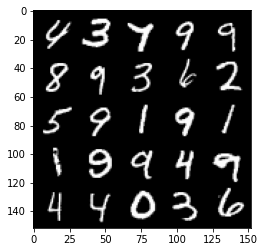

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 3.556899539947511, discriminator loss: 0.10101564843952647


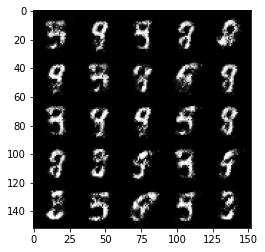

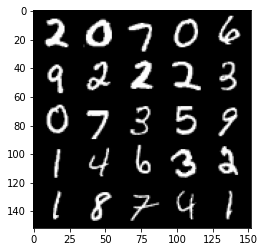

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 3.4735491290092493, discriminator loss: 0.12185490408539762


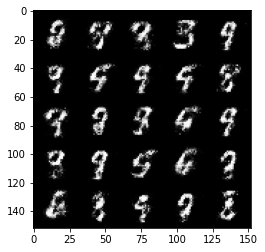

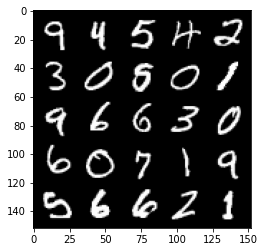

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 3.5717370891571045, discriminator loss: 0.11947327589243656


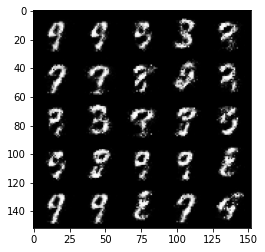

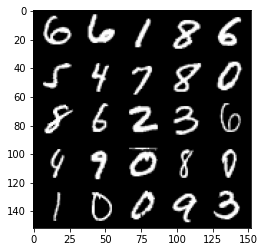

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 3.423689101219176, discriminator loss: 0.11842131967842577


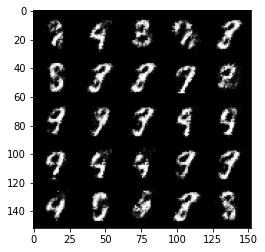

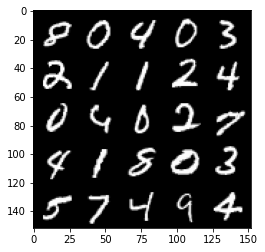

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 3.3951629247665442, discriminator loss: 0.11868664331734172


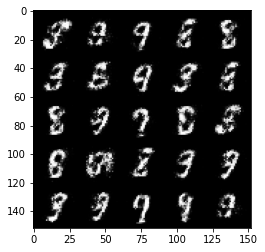

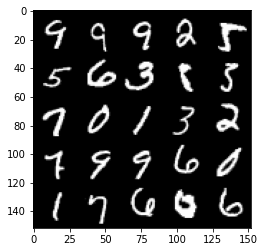

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 3.4871059908866853, discriminator loss: 0.13563105225563055


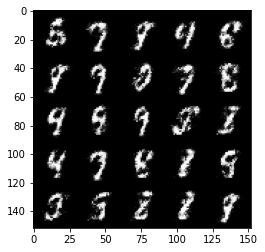

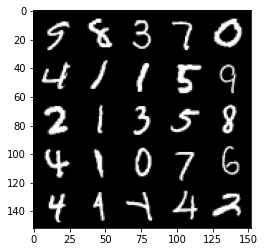

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 3.399783459186553, discriminator loss: 0.14474749490618713


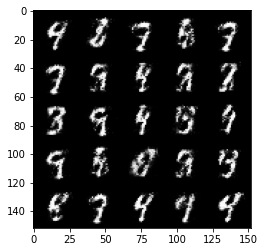

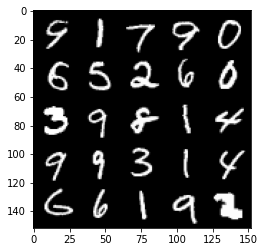

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 3.4866512422561633, discriminator loss: 0.12639812288433303


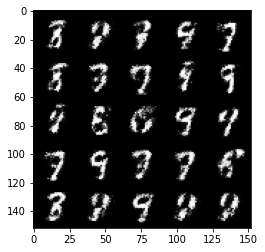

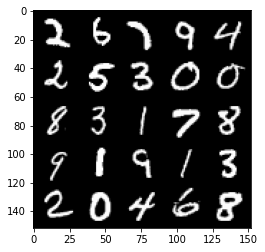

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 3.4074820652008047, discriminator loss: 0.1472231186926365


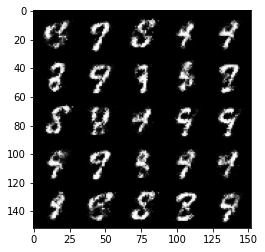

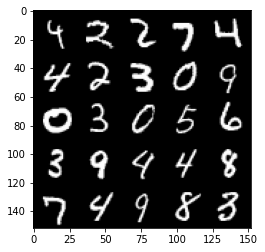

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 3.2703115072250375, discriminator loss: 0.14893605452775946


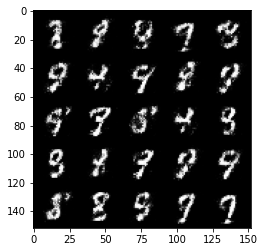

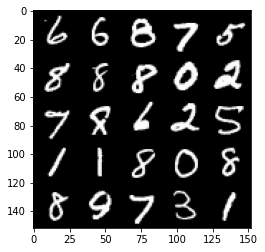

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 3.2817002902030974, discriminator loss: 0.15393714395165434


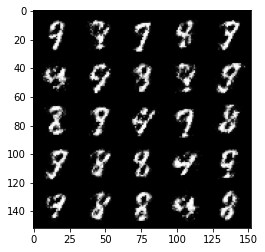

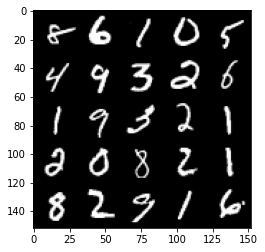

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 3.131271417617799, discriminator loss: 0.16974993179738512


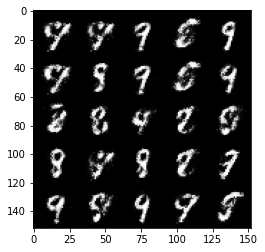

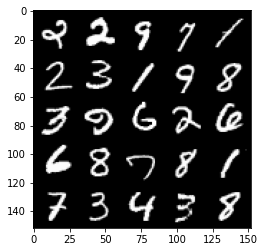

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 3.0877498974800135, discriminator loss: 0.1685849719643594


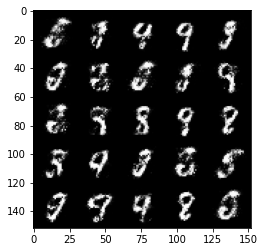

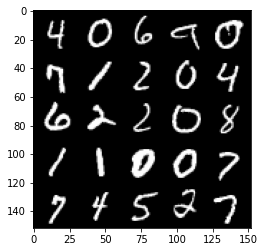

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 3.0430713291168177, discriminator loss: 0.16561772044003029


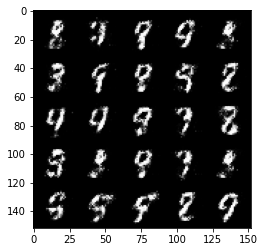

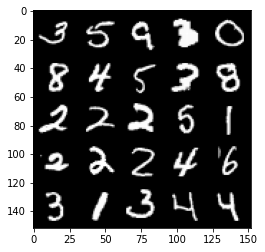

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 3.078830808639527, discriminator loss: 0.17246848557889488


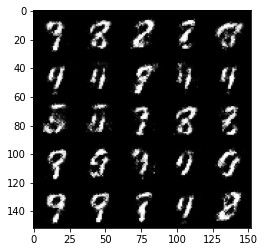

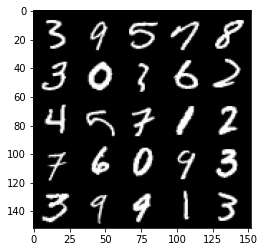

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
# UNQ_C8 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: 

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE ####
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        #### END CODE HERE ####

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1